# LIBRARIES

In [0]:
## import torch
import torchvision
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from torch.nn import functional as F
import time
import pandas as pd 
from random import shuffle

# Pull in MNIST Data

## MNIST Data Label Generation

In [0]:
def gen_mnist():
    from sklearn.datasets.base import get_data_home 
    from sklearn.datasets import fetch_mldata
    print (get_data_home())
    mnist_raw = fetch_mldata('MNIST original', data_home=get_data_home())
    mnist=mnistData(mnist_raw.target,mnist_raw.data) 
    cnt=len(mnist.label)
    labelset=torch.tensor(mnist.label)
    labelset.shape
    dataset=torch.tensor(mnist.x,dtype=torch.float)
    number_columns=dataset.shape[1]
    #dataset = dataset.view(-1,number_columns).float()/256.0
    print(dataset.shape)
    dataset=dataset.view(cnt,28,28)
    return(labelset, dataset)

# Classes

## Data Loaders

In [0]:
## CUSTOM DATA LOADER
from torch.utils.data.dataset import Dataset
class rgenData(Dataset):
    def __init__(self, randEnc, x, transform=None):
        self.randEnc= randEnc
        self.x=x 
    def __len__(self):
        z=self.x.shape[0]
        return  z
    def __getitem__(self, idx):
        randEnc=self.randEnc[idx]
        x=self.x[idx]
        return randEnc, x

## CUSTOM DATA LOADER
from torch.utils.data.dataset import Dataset
class mnistData(Dataset):
    def __init__(self, label, x, transform=None):
        self.label= label
        self.x=x 
    def __len__(self):
        z=self.x.shape[0]
        return  z
    def __getitem__(self, idx):
        label=self.label[idx]
        x=self.x[idx]
        return x

# Functions

In [0]:
def loss_function(recon_x, x):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    return(BCE)
def decode_loader(data, batch_size):
    perm = torch.randperm(data.size(0))
    idx = perm[:batch_size]
    batch=data[idx]
    return(batch)
def export_tensor(out_tensor,filename):
    arr = out_tensor.data.cpu().numpy()
    # write CSV
    np.savetxt(filename, arr)
def import_tensor(filename):
    from numpy import genfromtxt
    test = np.genfromtxt(filename)
    import_tensor=torch.tensor(test, dtype=torch.float)
    return(import_tensor)
def import_saved_output(filenames,loss_filename):
    imp_data=[]
    for i in range(0,len(filenames)):
        out_file='output/'+filenames[i]+'.csv'
        test=import_tensor(out_file)
        imp_data.append(test)
    test_lossvec = np.genfromtxt(loss_filename)
    return(imp_data, test_lossvec)
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor

def tensor_round(tensor):
    return torch.round(tensor)

# Data Generation

## Pull Indices and Labels

In [0]:
def get_images(img_return_cnt,labels_raw, data_raw):
    found=False
    img_agg_cnt=np.zeros(10)
    img_return_cnt=np.array(img_return_cnt)
    i=0
    labels=[]
    indices=[]
    while found==False and 70000>i:
        target=labels_raw[i]
        index=int(labels_raw[i].data)
        if np.dot(np.subtract(img_agg_cnt, img_return_cnt),np.ones(10))==0:
            found=True
        else:
            if img_agg_cnt[index] < img_return_cnt[index]:
                img_agg_cnt[index]+=1
                indices.append(i)
        i+=1
    return(indices)

## Gen Random Embeddings

In [0]:
def gen_rand_data(img_return_cnt,labels_raw, data_raw,Rdim):
    #num_img_type= scalar= equal to the number of image categories
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    #example_data = data loader data in form: batch_idx, (example_data, example_targets) 
    #max_i= data size
    #Rdim= vector dimension for rand generation
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    found=False
    img_agg_cnt=np.zeros(10)
    img_return_cnt=np.array(img_return_cnt)
    i=0
    first=True
    labels=[]
    indices=[]
    while found==False and 70000>i:
        target=labels_raw[i]
        index=int(labels_raw[i].data)
        if np.dot(np.subtract(img_agg_cnt, img_return_cnt),np.ones(10))==0:
            found=True
        else:
            if img_agg_cnt[index] < img_return_cnt[index]:
                labels.append(target.item())
                datum=data_raw[i].view(-1,28*28)
                img_agg_cnt[index]+=1
                indices.append(i)
                if first==True:
                    x_tensor=datum
                    randEnc_tensor=torch.rand(1, Rdim).cuda()
                    first=False 
                else:
                    omega=torch.rand(1, Rdim).cuda()
                    x_tensor=torch.cat((x_tensor,datum),0)
                    randEnc_tensor=torch.cat((randEnc_tensor,omega),0)
        i+=1
    data = rgenData(randEnc_tensor, x_tensor)
    return(data, labels, indices)

## Create RandEmbedding with Image Index

In [0]:
def get_randenc_byindex(indices, labels_raw, data_raw,Rdim):
    #num_img_type= scalar= equal to the number of image categories
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    #example_data = data loader data in form: batch_idx, (example_data, example_targets) 
    #max_i= data size
    #Rdim= vector dimension for rand generation
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    i=0
    cnt=len(indices)
    labels=[]
    datum=data_raw[indices[0]].view(-1,28*28)
    datum=min_max_normalization(datum, 0, 1)
    datum=tensor_round(datum)
    x_tensor=datum.cuda()
    randEnc_tensor=torch.rand(1, Rdim).cuda()
    labels.append(labels_raw[0])
    for i in range(1,len(indices)):
        index=indices[i]
        labels.append(labels_raw[index])
        datum=data_raw[index].view(-1,28*28)
        omega=torch.rand(1, Rdim).cuda()
        x_tensor=torch.cat((x_tensor,datum),0)
        randEnc_tensor=torch.cat((randEnc_tensor,omega),0)
    data = rgenData(randEnc_tensor, x_tensor)
    return(data, labels)

## Gen Dataset Given Image Index & Array of Embedding

In [0]:
def get_enc_img(indices,labels_raw, data_raw,embedding):
    #num_img_type= scalar= equal to the number of image categories
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    #example_data = data loader data in form: batch_idx, (example_data, example_targets) 
    #max_i= data size
    #Rdim= vector dimension for rand generation
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    i=0
    cnt=len(indices)
    labels=[]
    datum=data_raw[indices[0]].view(-1,28*28).cuda()
    x_tensor=datum
    randEnc_tensor=torch.tensor(embedding[0], dtype=torch.float).cuda()
    labels.append(labels_raw[0])
    for i in range(1,len(indices)):
        index=indices[i]
        labels.append(labels_raw[index])
        datum=data_raw[index].view(-1,28*28).cuda()
        omega=torch.tensor(embedding[i], dtype=torch.float).cuda()
        x_tensor=torch.cat((x_tensor,datum),0)
        randEnc_tensor=torch.cat((randEnc_tensor,omega),0)
    data = rgenData(randEnc_tensor, x_tensor)
    return(data, labels)

# Models

## Train Decoder

In [0]:
def train_decoder(epoch, data, model, optimizer,size,log_interval=10):
    train_loss = 0
    optimizer.zero_grad()
    lossvec=[]
    lossvec_cnt=[]
    cnt=0
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(
    model.parameters(), lr=LR, weight_decay=1e-5)
    for epoch in range(epoch):
      if epoch%500==0:
        print(epoch)
      for j in range(0,size):
        x=data.x[j]
        enc=data.randEnc[j]
        # ===================forward=====================
        encoded, decoded = model(enc)
        loss = criterion(decoded, x)
        MSE_loss = nn.MSELoss()(decoded, x)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    return(lossvec, lossvec_cnt, model)

In [33]:
'''
def train_decoder(epoch, data, model, optimizer,size,log_interval=10):
    train_loss = 0
    optimizer.zero_grad()
    lossvec=[]
    lossvec_cnt=[]
    cnt=0
    for i in range(1, epoch):
        train_loss = 0
        if i%10000==0:
            print(i)
        for j in range(0,size):
            x=data.x[j]
            randEnc=data.randEnc[j]
            cnt+=1
            encoded, decoded = model.forward(randEnc)
            loss = loss_function(decoded, x)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    i, batch_idx * len(x), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(x)))
          
        lossvec.append(train_loss / size)
        lossvec_cnt.append(i)
        
    return (lossvec, lossvec_cnt, model)'''


"\ndef train_decoder(epoch, data, model, optimizer,size,log_interval=10):\n    train_loss = 0\n    optimizer.zero_grad()\n    lossvec=[]\n    lossvec_cnt=[]\n    cnt=0\n    for i in range(1, epoch):\n        train_loss = 0\n        if i%10000==0:\n            print(i)\n        for j in range(0,size):\n            x=data.x[j]\n            randEnc=data.randEnc[j]\n            cnt+=1\n            encoded, decoded = model.forward(randEnc)\n            loss = loss_function(decoded, x)\n            loss.backward()\n            train_loss += loss.item()\n            optimizer.step()\n            \n            if batch_idx % log_interval == 0:\n                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(\n                    i, batch_idx * len(x), len(train_loader.dataset),\n                    100. * batch_idx / len(train_loader),\n                    loss.item() / len(x)))\n          \n        lossvec.append(train_loss / size)\n        lossvec_cnt.append(i)\n        \n    

## Train AE

In [0]:
def train_AE(epoch, data, model, optimizer,size,log_interval=10):
    train_loss = 0
    optimizer.zero_grad()
    lossvec=[]
    lossvec_cnt=[]
    cnt=0
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(
    model.parameters(), lr=LR, weight_decay=1e-5)
    for epoch in range(epoch):
      if epoch%500==0:
        print(epoch)
      for j in range(0,size):
        x=data.x[j]
        # ===================forward=====================
        encoded, decoded = model(x)
        loss = criterion(decoded, x)
        MSE_loss = nn.MSELoss()(decoded, x)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    return(lossvec, lossvec_cnt, model)

In [35]:
'''def train_AE(epoch, data, model, optimizer,size,log_interval=10):
    train_loss = 0
    optimizer.zero_grad()
    lossvec=[]
    lossvec_cnt=[]
    cnt=0
    for i in range(1, epoch):
        train_loss = 0
        if i%10000==0:
            print(i)
        for j in range(0,size):
            x=data.x[j]
            cnt+=1
            encoded, decoded = model(x)
            loss = loss_function(decoded, x)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
           
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    i, batch_idx * len(x), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(x)))
           
        lossvec.append(train_loss / size)
        lossvec_cnt.append(i)
        
    return (lossvec, lossvec_cnt, model)'''


"def train_AE(epoch, data, model, optimizer,size,log_interval=10):\n    train_loss = 0\n    optimizer.zero_grad()\n    lossvec=[]\n    lossvec_cnt=[]\n    cnt=0\n    for i in range(1, epoch):\n        train_loss = 0\n        if i%10000==0:\n            print(i)\n        for j in range(0,size):\n            x=data.x[j]\n            cnt+=1\n            encoded, decoded = model(x)\n            loss = loss_function(decoded, x)\n            train_loss += loss.item()\n            loss.backward()\n            optimizer.step()\n           \n            if batch_idx % log_interval == 0:\n                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(\n                    i, batch_idx * len(x), len(train_loader.dataset),\n                    100. * batch_idx / len(train_loader),\n                    loss.item() / len(x)))\n           \n        lossvec.append(train_loss / size)\n        lossvec_cnt.append(i)\n        \n    return (lossvec, lossvec_cnt, model)"

# Plotting

In [0]:
def x_xd_plot_compare(data,model,instances,ae=False): 
    rows=instances
    cols=2
    tot=int(instances)*cols
    fig = plt.figure(figsize=(rows, rows))
    plt.tight_layout() 
    # plot with various axes scales
    loc=0
    fig.subplots_adjust(hspace=.5)
    case=0
    while case<(rows):
        # linear
        loc+=1
        tensor=data[case][1].view(28,28)
        if ae==False:
            tensor_d=model.decode(data[case][0])
            encoded=data[case][0]
        else:
            encoded, tensor_d=model(data[case][1])
        Rdim=encoded.shape
        Rdim=Rdim[0]
        tensor_d_plt=tensor_d.view(28,28)
        plt.subplot(rows, cols, loc).axis('off')
        plt.imshow(tensor.cpu().detach().numpy(),cmap='gray')
        plt.title(str(case))


        loc+=1
        # log
        plt.subplot(rows, cols, loc).axis('off')
        plt.imshow(tensor_d_plt.cpu().detach().numpy(),cmap='gray')
        plt.title(str(case))


        if case==0:
            exp_tensor=data[case][1]
            exp_tensor_d=tensor_d
            exp_omega=encoded
        else:
            exp_tensor=torch.cat((exp_tensor,data[case][1]),0)
            exp_tensor_d=torch.cat((exp_tensor_d,tensor_d),0)
            exp_omega=torch.cat((exp_omega, encoded),0)
        case+=1

    plt.show()
    return(exp_tensor.view(instances,784),exp_tensor_d.view(instances,784),exp_omega.view(instances,Rdim))


# Experiments

In [37]:
'''from google.colab import drive
drive.mount('/content/gdrive')'''


"from google.colab import drive\ndrive.mount('/content/gdrive')"

In [0]:
exp_name="TEst_"
path="output/"

In [0]:
#labelset, dataset=gen_mnist()
EPOCH=1

## Import MNIST Data

In [40]:
print('cuda found')
#print(torch.cuda.is_available())

cuda found


In [41]:
labelset, dataset=gen_mnist()
labelset=labelset.cuda()
dataset=dataset.cuda()

/root/scikit_learn_data


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


torch.Size([70000, 784])


In [42]:
"""
import_file = np.genfromtxt('/content/gdrive/My Drive/mnist_labelset.txt')
labelset=torch.tensor(import_file).cuda()
#labelset=torch.tensor(import_file)
pd_dataset=pd.read_csv("/content/gdrive/My Drive/mnist_dataset.csv")
np_dataset=pd_dataset.as_matrix()
dataset_test=np_dataset.reshape(70000,28,28)
dataset=torch.tensor(dataset_test,dtype=torch.float).cuda()
#dataset=torch.tensor(dataset_test,dtype=torch.float"""

'\nimport_file = np.genfromtxt(\'/content/gdrive/My Drive/mnist_labelset.txt\')\nlabelset=torch.tensor(import_file).cuda()\n#labelset=torch.tensor(import_file)\npd_dataset=pd.read_csv("/content/gdrive/My Drive/mnist_dataset.csv")\nnp_dataset=pd_dataset.as_matrix()\ndataset_test=np_dataset.reshape(70000,28,28)\ndataset=torch.tensor(dataset_test,dtype=torch.float).cuda()\n#dataset=torch.tensor(dataset_test,dtype=torch.float'

In [43]:
'''
import_file = np.genfromtxt('mnist_labelset.txt')
labelset=torch.tensor(import_file).cuda()
#labelset=torch.tensor(import_file)
pd_dataset=pd.read_csv("mnist_dataset.csv")
np_dataset=pd_dataset.as_matrix()
dataset_test=np_dataset.reshape(70000,28,28)
dataset=torch.tensor(dataset_test,dtype=torch.float).cuda()
#dataset=torch.tensor(dataset_test,dtype=torch.float'''

'\nimport_file = np.genfromtxt(\'mnist_labelset.txt\')\nlabelset=torch.tensor(import_file).cuda()\n#labelset=torch.tensor(import_file)\npd_dataset=pd.read_csv("mnist_dataset.csv")\nnp_dataset=pd_dataset.as_matrix()\ndataset_test=np_dataset.reshape(70000,28,28)\ndataset=torch.tensor(dataset_test,dtype=torch.float).cuda()\n#dataset=torch.tensor(dataset_test,dtype=torch.float'

### Ref code for pulling images

## Gen Data by Dime

In [0]:
# Pull Random Encodings and Random Images

In [0]:
rdim=64
batch_size=4
ind_shuffle=[24755, 48200, 1, 18624, 0, 24754, 12666, 30596, 54051, 30597, 5924, 18623, 41935, 12665, 36017, 5923]
data, labels=get_randenc_byindex(ind_shuffle, labelset, dataset,rdim)

In [46]:
'''# Pull Images to go with ETF
embedding=np.matrix([[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1],
[1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1],
[1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1],
[1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1],
[1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1],
[1, -1, -1, -1,-1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1]])
embedding=embedding.transpose()


data, labels=get_enc_img(ind_shuffle,labelset, dataset,embedding)
'''



'# Pull Images to go with ETF\nembedding=np.matrix([[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1],\n[1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1],\n[1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1],\n[1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1],\n[1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1],\n[1, -1, -1, -1,-1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1]])\nembedding=embedding.transpose()\n\n\ndata, labels=get_enc_img(ind_shuffle,labelset, dataset,embedding)\n'

# AE Classes

In [0]:
class decode_sequential_6D1L(nn.Module):
    def __init__(self):
        super(decode_sequential_6D1L, self).__init__()
        self.decode = nn.Sequential(
            nn.Linear(6, 784),
            nn.Sigmoid())

    def forward(self, x):
        encoded = x
        decoded = self.decode(encoded)
        return encoded, decoded

In [0]:
class decode_sequential_6D2L(nn.Module):
    def __init__(self):
        super(decode_sequential_6D2L, self).__init__()
        self.decode = nn.Sequential(
            nn.Linear(6, 100),
            nn.ReLU(True),
            nn.Linear(100, 28 * 28),
            nn.Sigmoid())

    def forward(self, x):
        encoded = x
        decoded = self.decode(encoded)
        return encoded, decoded


In [0]:
class decode_sequential_6D3L(nn.Module):
    def __init__(self):
        super(decode_sequential_6D3L, self).__init__()
        self.decode = nn.Sequential(
            nn.Linear(6, 100),
            nn.ReLU(True),
            nn.Linear(100, 200),
            nn.ReLU(True),
            nn.Linear(200, 784),
            nn.Sigmoid())

    def forward(self, x):
        encoded = x
        decoded = self.decode(encoded)
        return encoded, decoded

In [0]:
class decode_sequential_6D4L(nn.Module):
    def __init__(self):
        super(decode_sequential_6D4L, self).__init__()
        self.decode = nn.Sequential(
            nn.Linear(6, 784),
            nn.ReLU(True),
            nn.Linear(784, 784),
            nn.ReLU(True),
            nn.Linear(784, 784),
            nn.ReLU(True),
            nn.Linear(784, 784),
            nn.Sigmoid())

    def forward(self, x):
        encoded = x
        decoded = self.decode(encoded)
        return encoded, decoded

In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True))
        self.decode = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid())

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

In [0]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True))
        self.decode = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid())
    def forward(self, x):
        encoded = x
        decoded = self.decode(encoded)
        return encoded, decoded

In [0]:
class autoencoder_3L(nn.Module):
    def __init__(self):
        super(autoencoder_3L, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
             nn.Linear(256,100),
            nn.ReLU(True),
            nn.Linear(100, 64),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(64, 100),
            nn.ReLU(True),
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [0]:
class decoder_3L(nn.Module):
    def __init__(self):
        super(decoder_3L, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
             nn.Linear(256,100),
            nn.ReLU(True),
            nn.Linear(100, 64),
            nn.ReLU(True))
        self.decode = nn.Sequential(
            nn.Linear(64, 100),
            nn.ReLU(True),
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid())

    def forward(self, x):
        encoded = x
        decoded = self.decode(encoded)
        return encoded, decoded

# Experiments

In [0]:
EPOCH=50000
exp_name="relu_decoder_"

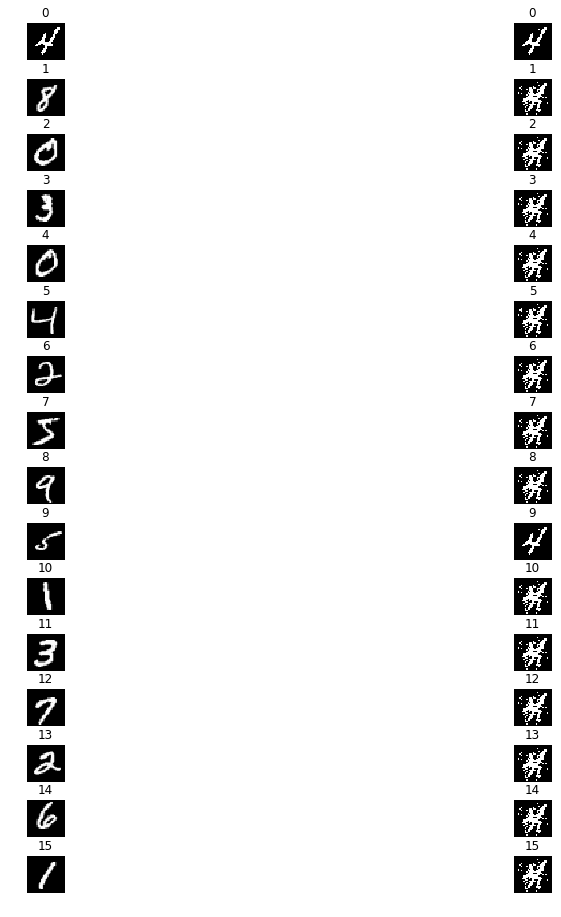

In [95]:
EPOCH=2000
model_tut = autoencoder().cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
model_tut.parameters(), lr=LR, weight_decay=1e-5)
size=16
for epoch in range(EPOCH):
    for j in range(0,size):
        img=data.x[j]
        # ===================forward=====================
        encoded, decoded = model_tut(img)
        loss = criterion(decoded, img)
        MSE_loss = nn.MSELoss()(decoded, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
tensor, tensor_d, omega=x_xd_plot_compare(data,model_tut,size,ae=True)


model loaded as cuda
<generator object Module.parameters at 0x7ff7eb3b8f10>
0
500
--- train mins %---
0.47191566228866577
TEst_


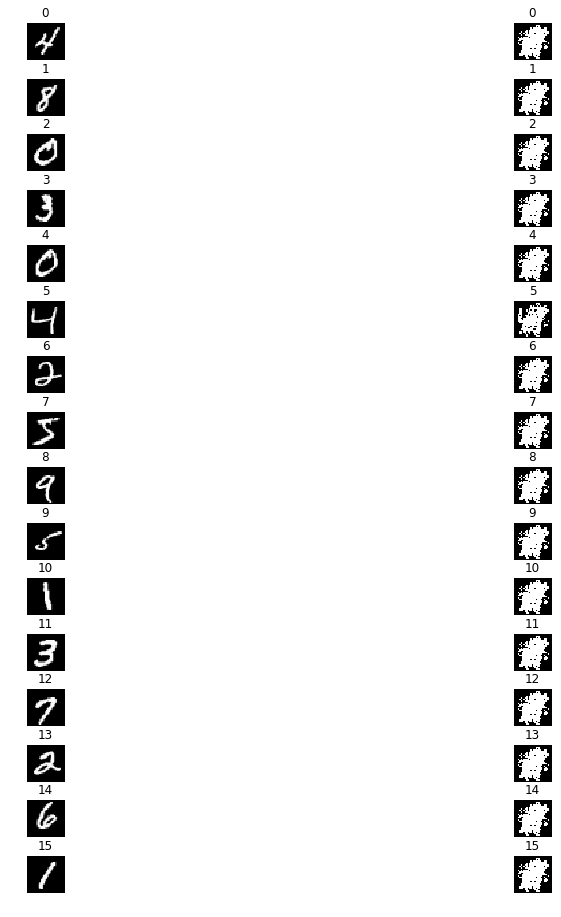

In [76]:
EPOCH=1000
expnum='1'
model_in =  autoencoder().cuda()
#model_in =   AE_1L50D()
print('model loaded as cuda')
print(model_in.parameters())
optimizer = torch.optim.Adam(model_in.parameters(), lr=LR, weight_decay=1e-5)
train_loss = 0
optimizer.zero_grad()

size=len(labels)
start_time = time.time()
lossvec, lossvec_cnt, model=train_AE(EPOCH,data,model_in, optimizer,size) 
print('--- train mins %---')
print((time.time() - start_time)/60)
######################################

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model_in,size,ae=True)


model loaded as cuda
<generator object Module.parameters at 0x7f965ab86570>
0
500
1000
1500
--- train mins %---
1.269085955619812
TEst_


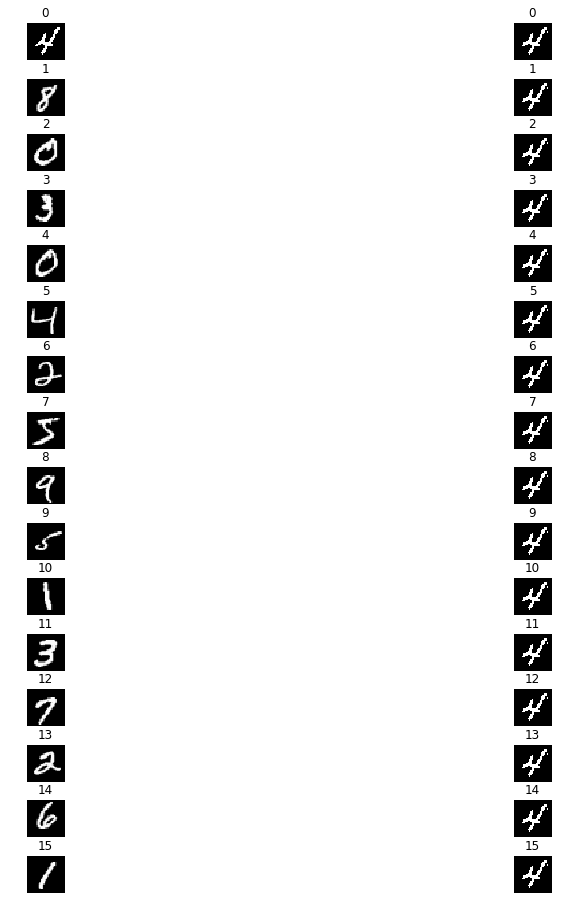

In [58]:
EPOCH=2000
expnum='1'
model_in =  autoencoder_3L().cuda()
#model_in =   AE_1L50D()
print('model loaded as cuda')
print(model_in.parameters())
optimizer = torch.optim.Adam(model_in.parameters(), lr=LR, weight_decay=1e-5)
train_loss = 0
optimizer.zero_grad()

size=len(labels)
start_time = time.time()
lossvec, lossvec_cnt, model=train_AE(EPOCH,data,model_in, optimizer,size) 
print('--- train mins %---')
print((time.time() - start_time)/60)
######################################

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model_in,size,ae=True)


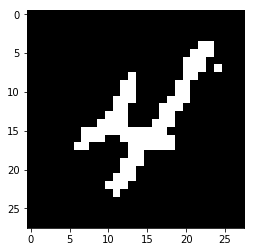

In [64]:
encoded, tensor_d=model(data[15][1])
tensor_d_plt=tensor_d.view(28,28)
plt.imshow(tensor_d_plt.cpu().detach().numpy(),cmap='gray')


model loaded as cuda
<generator object Module.parameters at 0x7f9650b9ff10>
0
500
1000
1500
2000
2500
3000
3500
--- train mins %---
1.2322856744130453
TEst_


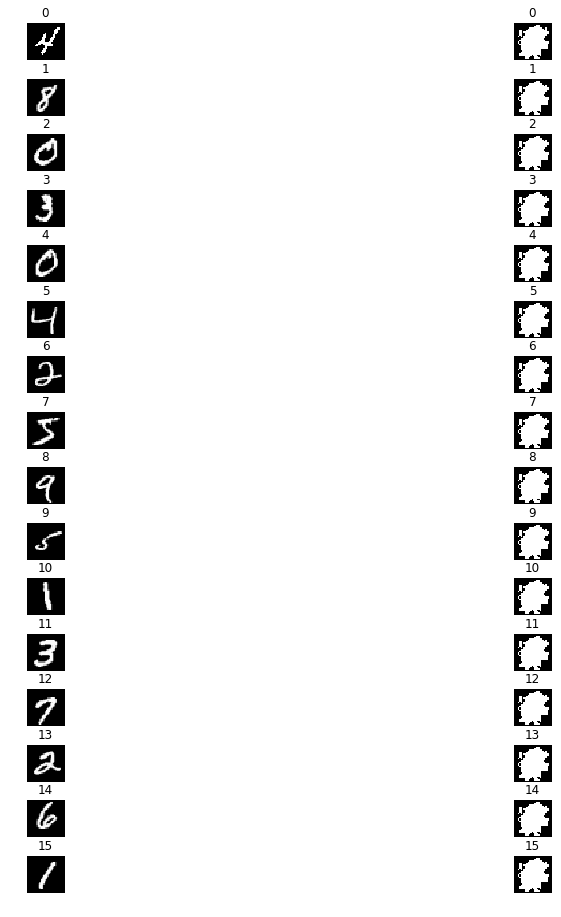

In [57]:
LR=0.005
EPOCH=4000
expnum='1'
model_in =  decoder().cuda()
#model_in =   AE_1L50D()
print('model loaded as cuda')
print(model_in.parameters())
optimizer = torch.optim.Adam(model_in.parameters(), lr=LR, weight_decay=1e-5)
train_loss = 0
optimizer.zero_grad()

size=len(labels)
start_time = time.time()
lossvec, lossvec_cnt, model=train_decoder(EPOCH,data,model_in, optimizer,size) 
print('--- train mins %---')
print((time.time() - start_time)/60)
######################################

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model_in,size)


model loaded as cuda
<generator object Module.parameters at 0x7f03010740a0>
0
500
--- train mins %---
0.39284063975016276
relu_decoder_


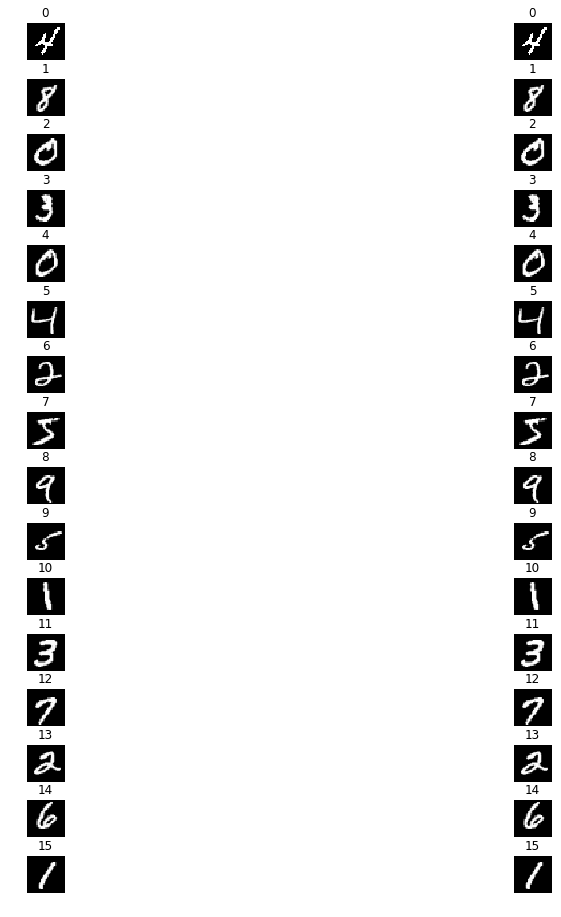

In [227]:
EPOCH=1000
expnum='1'
model_in =  decoder_3L().cuda()
#model_in =   AE_1L50D()
print('model loaded as cuda')
print(model_in.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
train_loss = 0
optimizer.zero_grad()

size=len(labels)
start_time = time.time()
lossvec, lossvec_cnt, model=train_decoder(EPOCH,data,model_in, optimizer,size) 
print('--- train mins %---')
print((time.time() - start_time)/60)
######################################

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model_in,size)


model loaded as cuda
<generator object Module.parameters at 0x7f03010e36d0>
--- train mins %---
0.21088324387868246
relu_decoder_


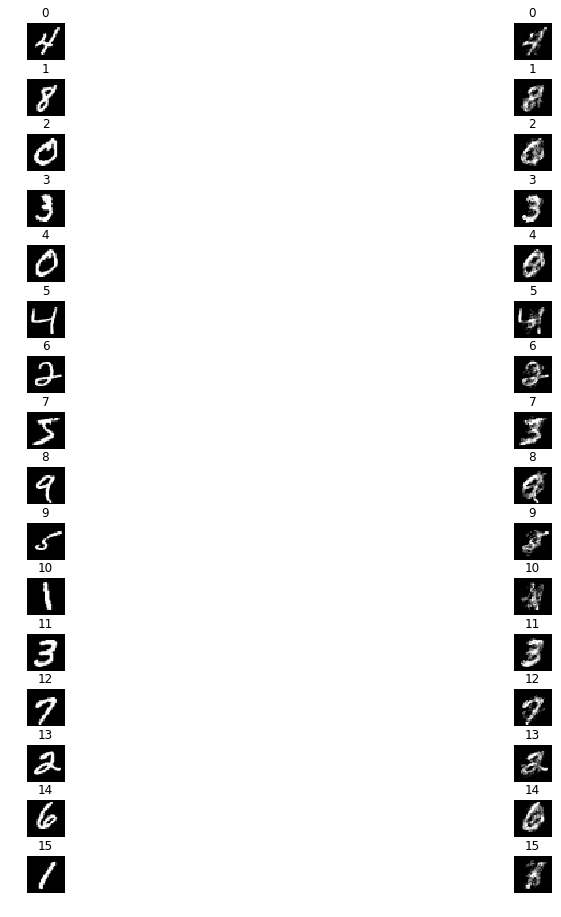

In [125]:
expnum='1'
model_in =  decode_sequential_6D1L().cuda()
#model_in =   AE_1L50D()
print('model loaded as cuda')
print(model_in.parameters())
optimizer = torch.optim.Adam(model_in.parameters(), lr=LR)
train_loss = 0
optimizer.zero_grad()

EPOCH=1000
size=len(labels)
start_time = time.time()
lossvec, lossvec_cnt, model=train_decoder(EPOCH,data,model_in, optimizer,size) 
print('--- train mins %---')
print((time.time() - start_time)/60)
######################################

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model_in,size)


### Run Code

model loaded as cuda
<generator object Module.parameters at 0x7f03012a49e8>
--- train mins %---
0.2778556982676188
relu_decoder_


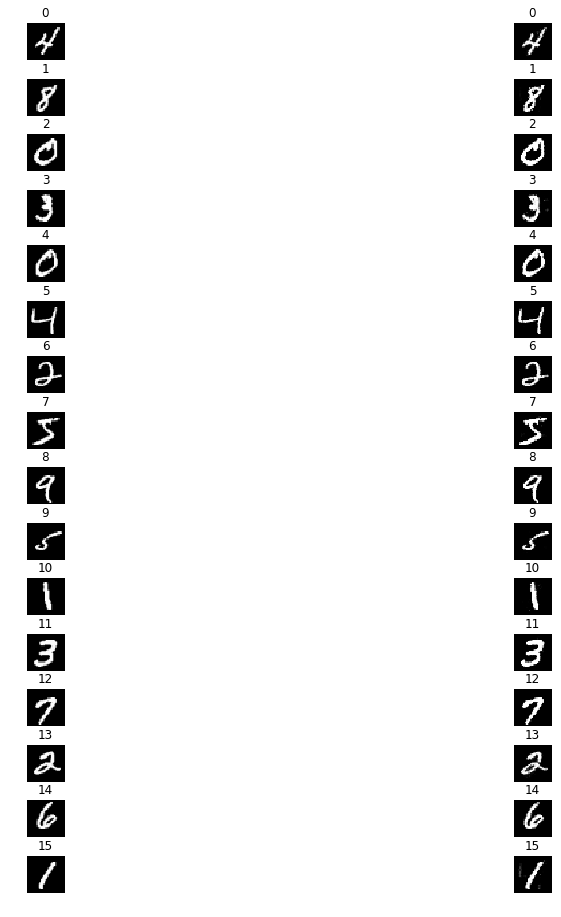

In [116]:
expnum='1'
model_in =  decode_sequential_6D2L().cuda()
#model_in =   AE_1L50D()
print('model loaded as cuda')
print(model_in.parameters())
optimizer = torch.optim.Adam(model_in.parameters(), lr=LR)
train_loss = 0
optimizer.zero_grad()

EPOCH=1000
size=len(labels)
start_time = time.time()
lossvec, lossvec_cnt, model=train_decoder(EPOCH,data,model_in, optimizer,size) 
print('--- train mins %---')
print((time.time() - start_time)/60)
######################################

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model_in,size)


model loaded as cuda
<generator object Module.parameters at 0x7f030118beb8>
--- train mins %---
3.4102563699086508
relu_decoder_


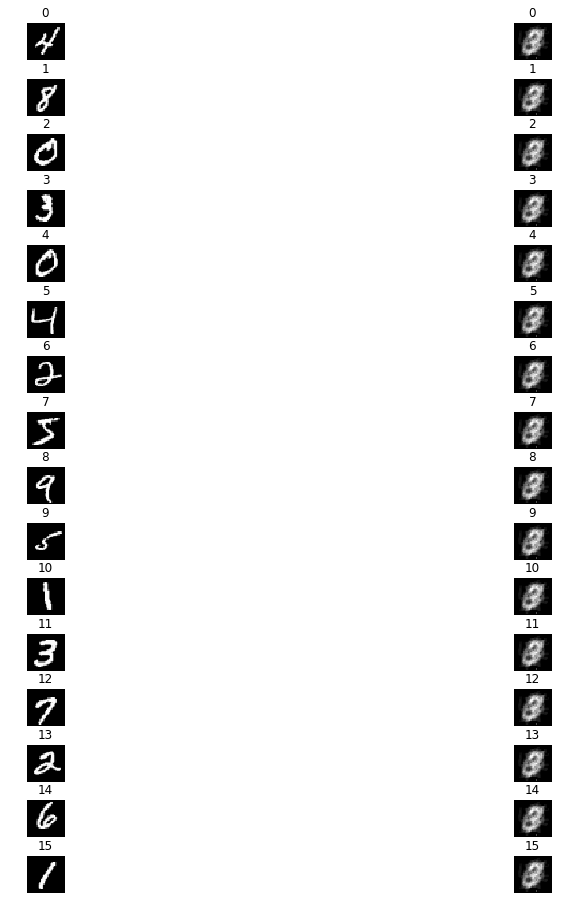

In [121]:
expnum='2'
model_in =  decode_sequential_6D3L().cuda()
#model_in =   AE_1L50D()
print('model loaded as cuda')
print(model_in.parameters())
optimizer = torch.optim.Adam(model_in.parameters(), lr=LR)
train_loss = 0
optimizer.zero_grad()

size=len(labels)
start_time = time.time()
lossvec, lossvec_cnt, model=train_decoder(EPOCH,data,model_in, optimizer,size) 
print('--- train mins %---')
print((time.time() - start_time)/60)
######################################

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model_in,size)


In [0]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_in.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
    
PATH=path+exp_name+'exp'+expnum+'model.pt'
torch.save(model_in.state_dict(), PATH)

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model,size,ae=True)

In [0]:
tensor_d_name=path+exp_name+'exp'+expnum+'_tensor_d'
tensor_name=path+exp_name+'exp'+expnum+'_tensor'
omega_name=path+exp_name+'exp'+expnum+'_omega'
loss_filename=path+exp_name+'exp'+expnum+'_lossvec.csv'
labels_filename=path+exp_name+'exp'+expnum+'_labels_test.csv'

filenames=[tensor_name, tensor_d_name, omega_name]
data_out=[]
data_out.append(tensor)
data_out.append(tensor_d)
data_out.append(omega)

for i in range(0,len(filenames)):
    out_file=filenames[i]+'.csv'
    export_tensor(data_out[i],out_file)
np.savetxt(loss_filename, lossvec)
np.savetxt(labels_filename, labels)

### Run Code

In [0]:
expnum='2'
model_in =   Decoder_2L_6D().cuda()
#model_in =   AE_1L50D()
print('model loaded as cuda')
print(model_in.parameters())
optimizer = torch.optim.Adam(model_in.parameters(), lr=LR)
train_loss = 0
optimizer.zero_grad()


In [0]:
size=len(labels)
start_time = time.time()
lossvec, lossvec_cnt, model=train_decoder(EPOCH,data,model_in, optimizer,size) 
print('--- train mins %---')
print((time.time() - start_time)/60)
######################################

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model,size)


In [0]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_in.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
    
PATH=path+exp_name+'exp'+expnum+'model.pt'
torch.save(model_in.state_dict(), PATH)

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model,size,ae=True)

In [0]:
tensor_d_name=path+exp_name+'exp'+expnum+'_tensor_d'
tensor_name=path+exp_name+'exp'+expnum+'_tensor'
omega_name=path+exp_name+'exp'+expnum+'_omega'
loss_filename=path+exp_name+'exp'+expnum+'_lossvec.csv'
labels_filename=path+exp_name+'exp'+expnum+'_labels_test.csv'

filenames=[tensor_name, tensor_d_name, omega_name]
data_out=[]
data_out.append(tensor)
data_out.append(tensor_d)
data_out.append(omega)

for i in range(0,len(filenames)):
    out_file=filenames[i]+'.csv'
    export_tensor(data_out[i],out_file)
np.savetxt(loss_filename, lossvec)
np.savetxt(labels_filename, labels)

### Run Code

In [0]:
expnum='3'
model_in =   Decoder_3L_6D().cuda()
#model_in =   AE_1L50D()
print('model loaded as cuda')
print(model_in.parameters())
optimizer = torch.optim.Adam(model_in.parameters(), lr=LR)
train_loss = 0
optimizer.zero_grad()


In [0]:
size=len(labels)
start_time = time.time()
lossvec, lossvec_cnt, model=train_decoder(EPOCH,data,model_in, optimizer,size) 
print('--- train mins %---')
print((time.time() - start_time)/60)
######################################

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model,size)


In [0]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_in.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
    
PATH=path+exp_name+'exp'+expnum+'model.pt'
torch.save(model_in.state_dict(), PATH)

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model,size,ae=True)

In [0]:
tensor_d_name= path+exp_name+'exp'+expnum+'_tensor_d'
tensor_name=path+exp_name+'exp'+expnum+'_tensor'
omega_name=path+exp_name+'exp'+expnum+'_omega'
loss_filename=path+exp_name+'exp'+expnum+'_lossvec.csv'
labels_filename=path+exp_name+'exp'+expnum+'_labels_test.csv'

filenames=[tensor_name, tensor_d_name, omega_name]
data_out=[]
data_out.append(tensor)
data_out.append(tensor_d)
data_out.append(omega)

for i in range(0,len(filenames)):
    out_file=filenames[i]+'.csv'
    export_tensor(data_out[i],out_file)
np.savetxt(loss_filename, lossvec)
np.savetxt(labels_filename, labels)

### Run Code

In [0]:
expnum='4'
model_in =   Decoder_4L_6D().cuda()
#model_in =   AE_1L50D()
print('model loaded as cuda')
print(model_in.parameters())
optimizer = torch.optim.Adam(model_in.parameters(), lr=LR)
train_loss = 0
optimizer.zero_grad()


In [0]:
size=len(labels)
start_time = time.time()
lossvec, lossvec_cnt, model=train_decoder(EPOCH,data,model_in, optimizer,size) 
print('--- train mins %---')
print((time.time() - start_time)/60)
######################################

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model,size)


In [0]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_in.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
    
PATH=path+exp_name+'exp'+expnum+'model.pt'
torch.save(model_in.state_dict(), PATH)

###############################################################################################################################
## UPDATE
print(exp_name)
tensor, tensor_d, omega=x_xd_plot_compare(data,model,size,ae=True)

In [0]:
tensor_d_name=path+exp_name+'exp'+expnum+'_tensor_d'
tensor_name=path+exp_name+'exp'+expnum+'_tensor'
omega_name=path+exp_name+'exp'+expnum+'_omega'
loss_filename=path+exp_name+'exp'+expnum+'_lossvec.csv'
labels_filename=path+exp_name+'exp'+expnum+'_labels_test.csv'

filenames=[tensor_name, tensor_d_name, omega_name]
data_out=[]
data_out.append(tensor)
data_out.append(tensor_d)
data_out.append(omega)

for i in range(0,len(filenames)):
    out_file=filenames[i]+'.csv'
    export_tensor(data_out[i],out_file)
np.savetxt(loss_filename, lossvec)
np.savetxt(labels_filename, labels)